In [5]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torchaudio

# scikit-learn imports
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import StandardScaler
from sklearn.pipeline           import Pipeline
from sklearn.ensemble           import RandomForestClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.semi_supervised    import LabelPropagation
from sklearn.metrics            import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) CONFIG ────────────────────────────────────────────────────────────────
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_CSV       = '/kaggle/input/pattern/data_labeled_filtered.csv'
AUDIO_ROOT     = '/kaggle/input/pattern/all_audio_files'
SAMPLES_PER_LABEL = 15000
N_MFCC         = 40
N_MELS         = 64
TEST_SIZE      = 0.2
RANDOM_STATE   = 42

In [6]:
# ─── 2) LOAD & BALANCE ─────────────────────────────────────────────────────────
df = pd.read_csv(DATA_CSV)
df_small = (
    df.groupby('label', group_keys=False)
      .sample(n=SAMPLES_PER_LABEL, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)
print("Per‐class counts:\n", df_small['label'].value_counts())

Per‐class counts:
 label
0    15000
1    15000
2    15000
3    15000
Name: count, dtype: int64


In [7]:
# ─── 3) PREPARE GPU-ACCELERATED TRANSFORMS (fixed) ────────────────────────────
n_fft      = 512      # gives you 512//2+1 = 257 freq bins
hop_length = 256
n_mels     = 64       # now safely <= 257

# MelSpectrogram with matching FFT params
melspec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
).to(DEVICE)

# MFCC uses the same mel-filterbank under the hood—so pass it via melkwargs
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=N_MFCC,
    melkwargs={
        'n_fft':       n_fft,
        'hop_length':  hop_length,
        'n_mels':      n_mels,
    }
).to(DEVICE)


In [8]:
# ─── 4) FEATURE EXTRACTION LOOP ────────────────────────────────────────────────
features, labels = [], []
for row in tqdm(df_small.itertuples(index=False), total=len(df_small), desc="Extracting"):
    path = os.path.join(AUDIO_ROOT, row.path)
    waveform, sr = torchaudio.load(path)         # waveform: [1, T]
    waveform = waveform.to(DEVICE)

    # optional silence clipping
    waveform = torch.where(waveform.abs() < 1e-4,
                           torch.zeros_like(waveform),
                           waveform)

    # 1) MFCC: [1, N_MFCC, T']
    mfcc = mfcc_transform(waveform)
    # 2) MelSpectrogram: [1, N_MELS, T']
    melspec = melspec_transform(waveform)

    # collapse time → mean & var vectors
    mfcc_mean = mfcc.mean(dim=2).squeeze(0)  # [N_MFCC]
    mfcc_var  = mfcc.var(dim=2).squeeze(0)
    spec_mean = melspec.mean(dim=2).squeeze(0)  # [N_MELS]
    spec_var  = melspec.var(dim=2).squeeze(0)

    feat = torch.cat([mfcc_mean, mfcc_var, spec_mean, spec_var], dim=0)
    features.append(feat.cpu().numpy())
    labels.append(row.label)

X = np.vstack(features)
y = np.array(labels)
print("X shape:", X.shape, "y shape:", y.shape)

Extracting:   0%|          | 0/60000 [00:00<?, ?it/s]

X shape: (60000, 208) y shape: (60000,)


In [9]:
# ─── 5) TRAIN/TEST SPLIT ───────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

In [11]:
from sklearn.decomposition import PCA

# 2) Fit PCA on train, transform both
pca = PCA(n_components=0.95, svd_solver='full')   # keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)


=== Tuning KNN_baseline ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9133

=== Tuning KNN_selectK ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9240

=== Tuning KNN_pca ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9155

--- Test results for KNN_baseline ---
              precision    recall  f1-score   support

    Male-20s     0.9341    0.8643    0.8979      3000
  Female-20s     0.9561    0.9363    0.9461      3000
    Male-50s     0.9129    0.9677    0.9395      3000
  Female-50s     0.9408    0.9740    0.9571      3000

    accuracy                         0.9356     12000
   macro avg     0.9360    0.9356    0.9351     12000
weighted avg     0.9360    0.9356    0.9351     12000



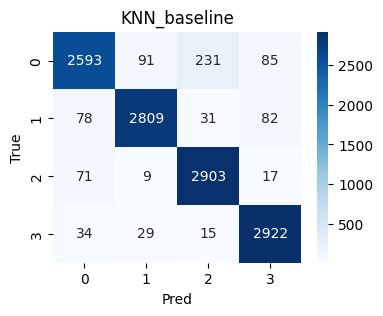


--- Test results for KNN_selectK ---
              precision    recall  f1-score   support

    Male-20s     0.9490    0.8677    0.9065      3000
  Female-20s     0.9609    0.9490    0.9549      3000
    Male-50s     0.9169    0.9750    0.9451      3000
  Female-50s     0.9478    0.9807    0.9640      3000

    accuracy                         0.9431     12000
   macro avg     0.9436    0.9431    0.9426     12000
weighted avg     0.9436    0.9431    0.9426     12000



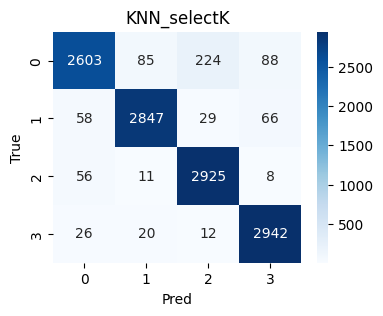


--- Test results for KNN_pca ---
              precision    recall  f1-score   support

    Male-20s     0.9346    0.8623    0.8970      3000
  Female-20s     0.9546    0.9387    0.9466      3000
    Male-50s     0.9166    0.9677    0.9415      3000
  Female-50s     0.9374    0.9733    0.9550      3000

    accuracy                         0.9355     12000
   macro avg     0.9358    0.9355    0.9350     12000
weighted avg     0.9358    0.9355    0.9350     12000



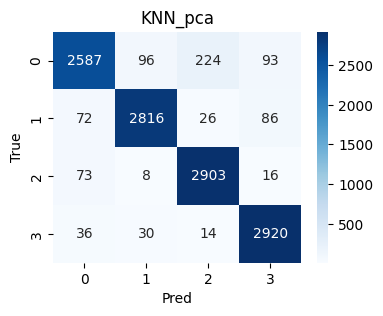

In [13]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines = {
    'KNN_baseline': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=100)),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

# 7) Light grid over k in [3,5,7,9]
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models = {}
for name, pipe in pipelines.items():
    print(f"\n=== Tuning {name} ===")
    # We only tune the 'knn' step in each pipeline
    grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(" Best k:", grid.best_params_['knn__n_neighbors'],
          "| CV acc:", f"{grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_

# 8) Evaluate all three
for name, model in best_models.items():
    print(f"\n--- Test results for {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(
        y_test, y_pred,
        target_names=['Male-20s','Female-20s','Male-50s','Female-50s'],
        digits=4
    ))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
    plt.title(name)
    plt.xlabel('Pred'); plt.ylabel('True')
    plt.show()